In [2]:
from epymorph.adrio import acs5
from epymorph import *  # noqa: F403
from epymorph.geography.us_census import StateScope
from epymorph.data.ipm.sirh import SIRH
from epymorph.data.mm.no import No
from epymorph.initializer import Proportional
from epymorph.rume import SingleStrataRUME
from epymorph.time import TimeFrame
import numpy as np

duration = 7 * 53 + 1
t = np.arange(0, duration)
true_beta = 0.03 * np.cos(t * 2 * np.pi / (365)) + 0.28

rume = SingleStrataRUME.build(
    ipm=SIRH(),
    mm=No(),
    scope=StateScope.in_states(["AZ"], year=2015),
    init=Proportional(ratios=np.array([9999, 1, 0, 0], dtype=np.int64)),
    time_frame=TimeFrame.of("2022-10-01", duration),
    params={
        "beta": true_beta,
        "gamma": 0.25,
        "xi": 1 / 365,  # 0.0111,
        "hospitalization_prob": 0.01,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
    },
)

In [3]:
from epymorph.parameter_fitting.dynamics import (
    GeometricBrownianMotion,
)
from epymorph.parameter_fitting.utils.parameter_estimation import EstimateParameters
from epymorph.parameter_fitting.utils.particle_initializer import ParticleInitializer

In [4]:
from epymorph.parameter_fitting.distribution import Uniform

params_space = {
    "beta": EstimateParameters.TimeVarying(
        distribution=Uniform(a=0.05, b=0.5),
        dynamics=GeometricBrownianMotion(volatility=0.04),
    )
}

In [5]:
initializer = ParticleInitializer(100, rume, params_space)
rng = np.random.default_rng(seed=1)
particles = initializer.initialize_particles(rng)

In [6]:
from epymorph.parameter_forecasting.forecast2_simulation import ForecastSimulator


forecast_sim = ForecastSimulator(rume)

In [ ]:
(
    state_forecast,
    param_forecast,
    param_quantiles,
    param_values,
    all_particle_params_per_day,
) = forecast_sim.run(particles, params_space)

In [7]:
import time

start_time = time.time()
(
    state_forecast,
    param_forecast,
    param_quantiles,
    param_values,
    all_particle_params_per_day,
) = forecast_sim.run(particles, params_space)
end_time = time.time()
time_taken = end_time - start_time

print(f"Time taken to run the forecast simulation: {time_taken} seconds")


Time taken to run the forecast simulation: 9.264471054077148 seconds


In [8]:
len(state_forecast)

100

In [9]:
state_forecast

[Output(rume=SingleStrataRUME(strata=[GPM(name='all', ipm=<epymorph.data.ipm.sirh.SIRH object at 0x000002664A500F90>, mm=<epymorph.data.mm.no.No object at 0x000002664AF54390>, init=<epymorph.initializer.Explicit object at 0x000002665D01F010>, params=None)], ipm=<epymorph.data.ipm.sirh.SIRH object at 0x000002664A500F90>, mms=OrderedDict([('all', <epymorph.data.mm.no.No object at 0x000002664AF54390>)]), scope=StateScope(year=2015, granularity='state', includes_granularity='state', includes=('04',), _node_ids=array(['04'], dtype='<U2')), time_frame=TimeFrame(start_date=datetime.date(2022, 10, 1), duration_days=372, end_date=datetime.date(2023, 10, 7)), params={NamePattern(strata='*', module='*', id='beta'): array([0.31      , 0.30999556, 0.30998222, 0.30996   , 0.30992891,
        0.30988895, 0.30984012, 0.30978246, 0.30971597, 0.30964068,
        0.3095566 , 0.30946377, 0.3093622 , 0.30925194, 0.309133  ,
        0.30900543, 0.30886927, 0.30872456, 0.30857133, 0.30840963,
        0.30823

In [10]:
param_forecast

{'beta': array([0.28035021, 0.28279388, 0.28321713, 0.28374219, 0.28410591,
        0.28498748, 0.28550292, 0.28696495, 0.28741253, 0.28812479,
        0.2919899 , 0.29295835, 0.29376458, 0.29557298, 0.29498376,
        0.29549904, 0.29517684, 0.29612609, 0.29683751, 0.29780893,
        0.29742714, 0.29632817, 0.29507879, 0.29521865, 0.29498401,
        0.29883937, 0.29772348, 0.2995585 , 0.29751543, 0.29958851,
        0.29911192, 0.29733796, 0.29906262, 0.2998264 , 0.29924285,
        0.30073122, 0.30277593, 0.30015095, 0.2989989 , 0.29934691,
        0.29882873, 0.29870029, 0.29852695, 0.29661595, 0.29834835,
        0.29943841, 0.29760225, 0.29557739, 0.29634657, 0.29486425,
        0.29503811, 0.29840329, 0.29757246, 0.29662122, 0.29889812,
        0.30152957, 0.304032  , 0.30501527, 0.30320808, 0.3072562 ,
        0.30734326, 0.30709143, 0.30993264, 0.30965815, 0.30775091,
        0.30978065, 0.30939363, 0.31158699, 0.31207955, 0.31328004,
        0.31252209, 0.31052773, 0.309880

In [11]:
all_particle_params_per_day.shape

(372,)

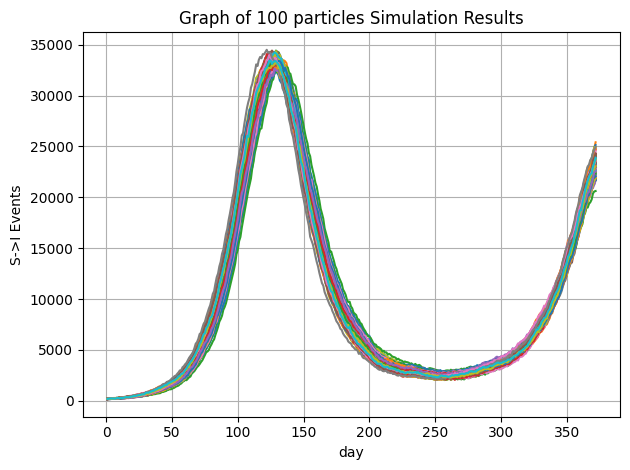

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# This uses the more advanced line_plt() functionality
for j in state_forecast:
    j.plot.line_plt(
        ax=ax,
        geo=j.rume.scope.select.all(),
        time=j.rume.time_frame.select.all(),
        quantity=j.rume.ipm.select.events("S->I"),
    )

ax.set_xlabel("day")
ax.set_ylabel("S->I Events")
ax.set_title("Graph of 100 particles Simulation Results")
ax.grid(True)

fig.tight_layout()
plt.show()

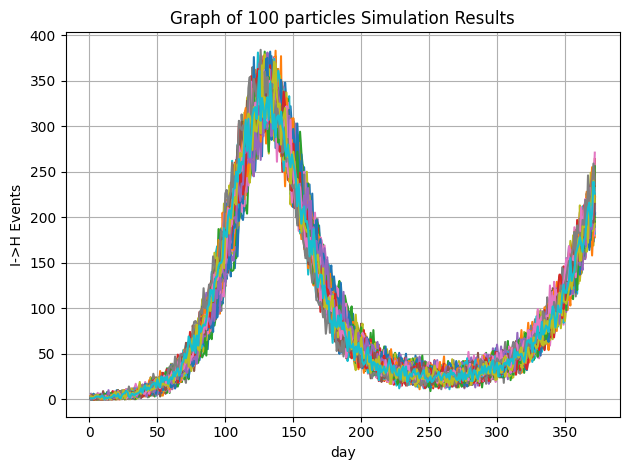

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# This uses the more advanced line_plt() functionality
for j in state_forecast:
    j.plot.line_plt(
        ax=ax,
        geo=j.rume.scope.select.all(),
        time=j.rume.time_frame.select.all(),
        quantity=j.rume.ipm.select.events("I->H"),
    )

ax.set_xlabel("day")
ax.set_ylabel("I->H Events")
ax.set_title("Graph of 100 particles Simulation Results")
ax.grid(True)

fig.tight_layout()
plt.show()

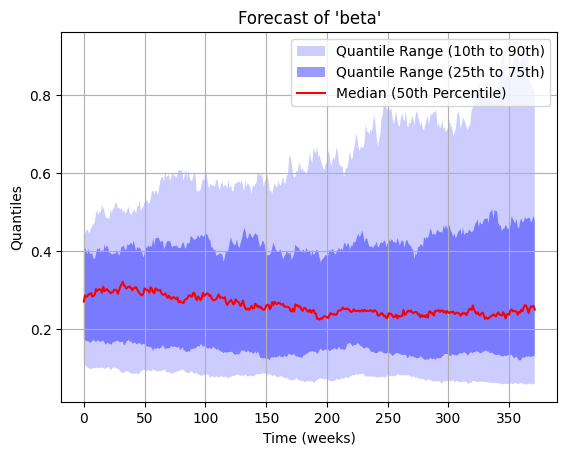

In [14]:
import matplotlib.pyplot as plt

key = "beta"
node_index = 0
truth = None

key_quantiles = np.array(param_quantiles[key])

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 3, 0],
    key_quantiles[:, 22 - 3, 0],
    facecolor="blue",
    alpha=0.2,
    label="Quantile Range (10th to 90th)",
)

plt.fill_between(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 6, 0],
    key_quantiles[:, 22 - 6, 0],
    facecolor="blue",
    alpha=0.4,
    label="Quantile Range (25th to 75th)",
)

plt.plot(
    np.arange(0, len(key_quantiles)),
    key_quantiles[:, 11, 0],
    color="red",
    label="Median (50th Percentile)",
)


plt.title(f"Forecast of '{key}'")
plt.xlabel("Time (weeks)")
plt.ylabel("Quantiles")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

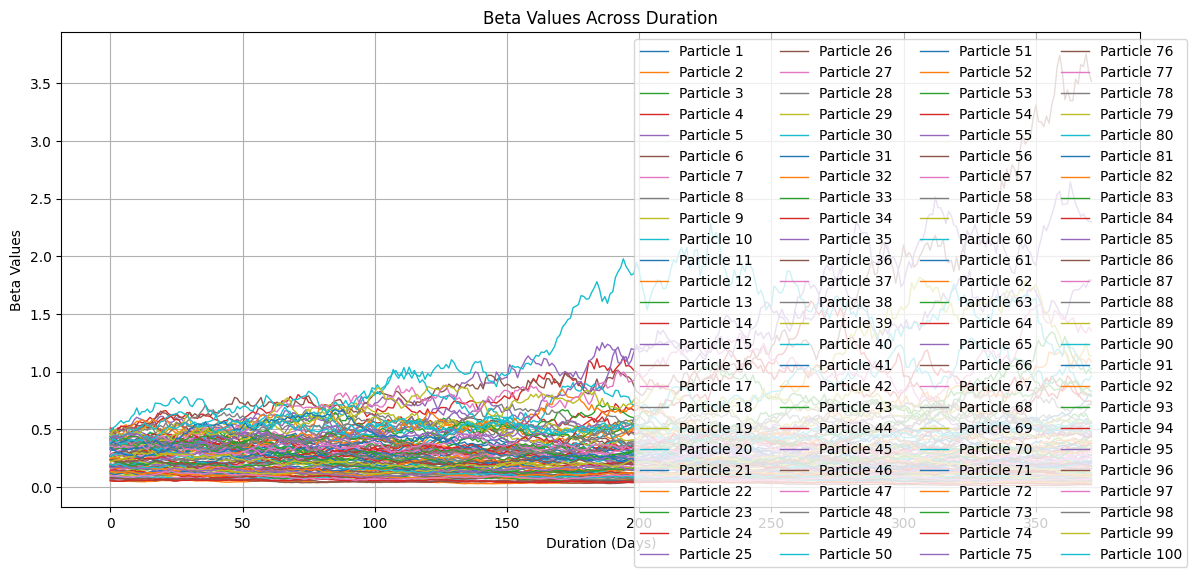

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def plot_beta_values_over_duration(all_particle_params_per_day, key="beta"):
    """
    Plot the beta parameter values for each particle over the entire duration.

    Parameters:
    - all_particle_params_per_day (np.array): The data structure where each entry corresponds to a day's parameters (in dictionary format).
    - key (str): The key to plot (e.g., 'beta').
    """
    # Number of particles (assuming all days have the same number of particles)
    num_particles = len(
        all_particle_params_per_day[0][key]
    )  # Get number of particles (from the first day)
    duration = len(all_particle_params_per_day)  # Number of days (duration)

    # Create a figure for plotting
    plt.figure(figsize=(12, 6))

    # Plot the beta values for each particle
    for particle_idx in range(num_particles):
        particle_beta_values = []

        # Collect the beta values for this particle over all days
        for day_idx in range(duration):
            particle_beta_values.append(
                all_particle_params_per_day[day_idx][key][particle_idx]
            )

        # Plot the particle's beta values across the duration
        plt.plot(
            range(duration),
            particle_beta_values,
            label=f"Particle {particle_idx + 1}",
            linewidth=1,
        )

    # Add labels and title
    plt.title(f"{key.capitalize()} Values Across Duration")
    plt.xlabel("Duration (Days)")
    plt.ylabel(f"{key.capitalize()} Values")
    plt.legend(
        loc="upper right", bbox_to_anchor=(1.05, 1), ncol=4
    )  # Adjust legend placement to avoid overlap
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()


# Example usage
# Assuming `all_particle_params_per_day` is a numpy array of shape (duration, num_particles), each entry being a dictionary like {'beta': [val1, val2, ...]}
# Plot the 'beta' values across the duration
plot_beta_values_over_duration(all_particle_params_per_day, key="beta")


In [16]:
import numpy as np


def plot_param_values_over_duration(
    all_particle_params_per_day, keys=["beta"], particles=None
):
    """
    Plot the parameter values for selected particles across the entire duration.

    Parameters:
    - all_particle_params_per_day (np.array): The data structure where each entry corresponds to a day's parameters (in dictionary format).
    - keys (list of str): List of keys (parameters) to plot (e.g., ['beta', 'alpha']).
    - particles (list of int, optional): List of particle indices to plot. If None, all particles will be plotted.
    """
    # Number of particles (assuming all days have the same number of particles)
    num_particles = len(
        all_particle_params_per_day[0][keys[0]]
    )  # Get number of particles (from the first day)
    duration = len(all_particle_params_per_day)  # Number of days (duration)

    # If particles is None, plot all particles
    if particles is None:
        particles = range(num_particles)

    # Create a figure for plotting
    plt.figure(figsize=(12, 6))

    # Loop through each key and plot its values
    for key in keys:
        for particle_idx in particles:
            # Collect the values for this particle and key (over all days)
            particle_values = [
                all_particle_params_per_day[day_idx][key][particle_idx]
                for day_idx in range(duration)
            ]

            # Plot the particle's values for this key across the duration
            plt.plot(
                range(duration),
                particle_values,
                label=f"Particle {particle_idx + 1} - {key.capitalize()}",
                linewidth=1,
            )

    # Add labels and title
    plt.title(f"Parameter Values ({', '.join(keys)}) Across Duration")
    plt.xlabel("Duration (Days)")
    plt.ylabel("Parameter Values")
    plt.legend(
        loc="upper right", bbox_to_anchor=(1.05, 1)
    )  # Adjust legend placement to avoid overlap
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.show()

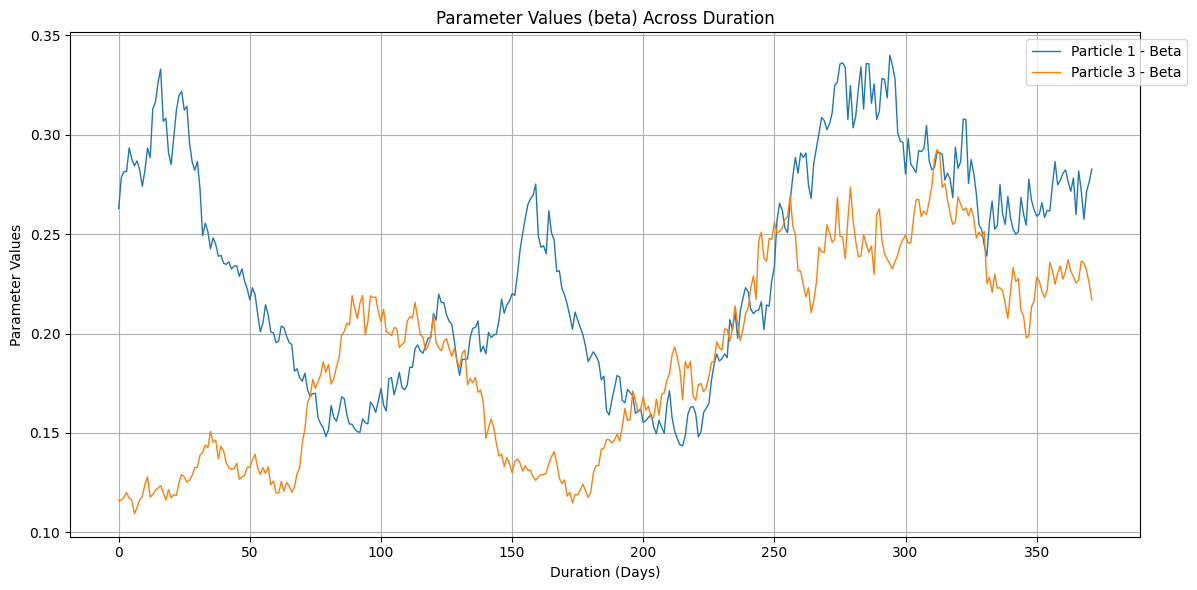

In [17]:
plot_param_values_over_duration(
    all_particle_params_per_day, keys=["beta"], particles=[0, 2]
)
